# <center>Organizaci&oacute;n de Datos</center>
## <center>Ensamble</center>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer, f1_score, confusion_matrix, precision_score, recall_score, accuracy_score
from nltk.corpus import stopwords

Importamos el dataframe

In [2]:
df = pd.read_csv("dataset/train.csv")
df.head(5)

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo


Realizamos una limpieza de los textos, incluyendo agregar las stopwords en español:

In [3]:
df['review_es'].isnull().sum()
df['sentimiento_es_positivo'] = np.where(df.sentimiento == 'positivo', 1, 0)
df['review_es'] = df['review_es'].str.lower()

caracteres_especiales = {'á':'a', 'é':'e', 'í':'i', 'ó':'o', 'ú':'u', 'ñ':'n'}
for original, nuevo in caracteres_especiales.items():
    df['review_es'] = df['review_es'].str.replace(original, nuevo, regex=True)
    
df['review_es'] = df['review_es'].str.replace('[^a-zA-Z]', ' ', regex=True)
df['review_es'] = df['review_es'].str.replace('  ', ' ', regex=True)

from nltk.corpus import stopwords
palabras = '|'.join(stopwords.words('spanish'))
df['review_es'] = df['review_es'].str.replace(fr'\b({palabras})\b', '',regex=True)

In [ ]:
Realizamos la tokenizacion de los textos, utilizando las herramientas que provee sklearn

In [4]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

X = df.review_es
y = df.sentimiento_es_positivo

vectorizador = CountVectorizer()
escaladorTfidf = TfidfTransformer()

X = vectorizador.fit_transform(X)
X = escaladorTfidf.fit_transform(X)

2023-06-28 11:27:42.016365: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 11:27:42.709101: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-28 11:27:42.711260: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-28 11:27:44.568476: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Separamos el dataest en entrenamiento y validacion, declarando una semilla para que sea repetible el experimento

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=777)

Como Ensamble vamos a realizar un Bagging, utilizando como 'weak learner' a naive bayes (en especifico MultinomialNB).

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier

clasificadorBayesNaive = MultinomialNB()

bag_clf = BaggingClassifier(
    clasificadorBayesNaive,
    bootstrap=True,
    n_estimators=250,
    max_samples=2000,
    oob_score=True
    )

bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=MultinomialNB(), max_samples=2000, n_estimators=250,
                  oob_score=True)

Podemos ver el 'oob_score' del ensamble bagging, que vendria siendo el score del modelo en la parte del dataset que no elige cuando realiza el bootstrap:

In [8]:
bag_clf.oob_score_

0.829025

Accuracy: 0.8294
Precision: 0.8795728243581005
Recall: 0.7669902912621359
F1-score: 0.8194326841659609


Text(0.5, 1.0, 'Confusion matrix de validación')

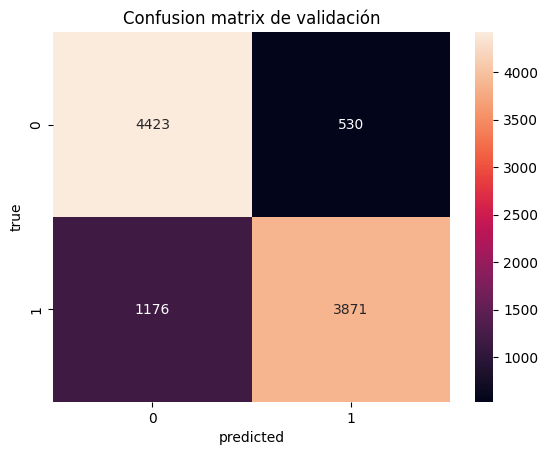

In [9]:
y_pred = np.where(bag_clf.predict(X_val) >= 0.5, 1, 0)
confusion = confusion_matrix(y_val, y_pred)
sns.heatmap(confusion, annot=True, fmt='.0f')

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1-score:", f1_score(y_val, y_pred))

plt.ylabel('true')
plt.xlabel('predicted')
plt.title("Confusion matrix de validación")

# Creacion de submit para kaggle

In [10]:
df_test = pd.read_csv("dataset/test.csv")
assert(len(df_test)==8599)

X_sumbit = df_test['review_es']
X_sumbit = vectorizador.transform(X_sumbit)
X_sumbit = escaladorTfidf.transform(X_sumbit)
    
prediccion = np.where(bag_clf.predict(X_sumbit) >= 0.5, 'positivo', 'negativo')

assert(len(prediccion)==8599)

submit = pd.DataFrame(
    {"sentimiento": prediccion},
    index=df_test["ID"],
)
assert(len(submit)==8599)

submit.to_csv("dataset/submit.csv")